# Estimating MI by noise contrastive method (InfoNCE)

## Setup

The following cell imports the necessary packages:

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
from torch.autograd import Variable
import itertools
from tqdm import tqdm
from data.mix_gaussian import MixedGaussian
from data.gaussian import Gaussian
from model.utils import *
from torch.utils.tensorboard import SummaryWriter   
import datetime

Use GPU if GPU is available.

In [25]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

name = './results/InfoNCE'   # filename
chkpt_name = name+'.pt'      # checkpoint
writer = SummaryWriter('./results/log/InfoNCE')

Set random seed for reproducibility.

In [26]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

Specify the hyper-parameters:

In [27]:
# arguments
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=6, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=0, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_iters", type=int, default=60000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--c_0_1_ratio", type=float, default=1, help="Ratio of samples with label 0 and samples with label 1 ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")

opt, unknown = parser.parse_known_args()

Specify the distribution to generate the data samples:

In [28]:
# Two choices here: 'Gaussian' and 'MixedGaussian'
density = 'Gaussian'

## Model

Define the function `generate_data` for generating Gaussian or Mixed Gaussian distributions.

- When generating Gaussian distrition, ${X}$ and ${Y}$ are distributed as 

\begin{align}
p_{XY} = \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & \rho \\ \rho & 1\\ \end{bmatrix} \right)
\end{align}

- When generating Mixed Gaussian distributions, ${X}$ and ${Y}$ are distributed as 

\begin{align} 
p_{XY} = \frac{1}{2} \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & \rho \\ \rho & 1\\ \end{bmatrix} \right) 
+ \frac{1}{2} \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & {-} \rho \\ {-} \rho & 1\\ \end{bmatrix} \right)
\end{align}

In [29]:
def generate_data(distribution='Gaussian', rho=0.9):
    # rho is the covariance for generating distributions
    # mu1 and mu2 are means for generating Mixed Gaussian distribution 
    mu1 = 0
    mu2 = 0

    # mg is an object of Class Gaussian or MixedGaussian
    if distribution=='Gaussian':
        mg = Gaussian(sample_size=opt.sample_size,rho=rho)
    else:
        mg = MixedGaussian(sample_size=opt.sample_size, mean1=mu1, mean2=mu2,rho1=rho, rho2=-rho)

    # Calculate the ground truth MI between X and Y for (X, Y) from mg
    mi = mg.ground_truth * opt.d

    # Create X, Y for storing generated samples
    X = np.zeros((opt.sample_size,opt.d))
    Y = np.zeros((opt.sample_size,opt.d))

    # Generate samples of random variable X,Y and XY
    for j in range(opt.d):
        # In each iteration, mg.data will generate samples of two dimensions where one dimension for X and another for Y respectively 
        data = mg.data
        X[:,j] = data[:,0]
        Y[:,j] = data[:,1]        
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    XY = torch.cat((X, Y), dim=1)

    return XY, X, Y, mi

Define the neural network.

In [30]:
class Net(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)

        return output

The function `_resample` below is for resampling the given data samples for training the neural network.

In [31]:
def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch

The function `infonce_loss` below returns the empirical estimate of the following infoNCE lower bound on the mutual information $I(X\wedge Y)$:

\begin{align}
I_{\text{infoNCE}}(f) := E\left[\log \frac{e^{f(X, Y)}}{E \left[\left. e^{f( X, Y')} \right| X \right]} \right] \leq I(X\wedge Y) 
\end{align}

where $f: \mathcal{X}\times \mathcal{Y}\to \mathbb{R}$ is a function to be implemented by a neural network, and $p_{Y'|X,Y}(y'|x,y)=p_{Y}(y)$, i.e., $Y'$ is identically distributed as $Y$ and independent of $(X,Y)$.


In [32]:
def infonce_loss(net, x_samples, y_samples):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))

    lower_bound = T0.mean() - (T1.logsumexp(dim = 1).mean() - np.log(sample_size))
    return lower_bound

The neural network `discriminator` below implements $f$:

In [33]:
discriminator = Net(input_size=opt.d*2, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Load previous results.

In [34]:
load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

Previous results loaded.


## Training

Since maximizing the infoNCE bound over $f$ attains the mutual information

\begin{align}
I(X\wedge Y) = \sup_{f} I_{\text{infoNCE}}(f),
\end{align}

we train the neural network to minimize the loss $-I_{\text{infoNCE}}(f)$. The optimal solution $f$ satisfies

\begin{align}
f(x,y)=\log \frac{p_{Y|X}(y|x)}{p_{Y}(y)} + c \quad \forall x\in \mathcal{X}, y \in \mathcal{Y}
\end{align}

for any constant $c$.

The following cell train the neural network using the data samples.

In [35]:
XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)

continue_train = False  # set to True to continue to train
if continue_train:
    for i in range(opt.n_iters):
        data_joint = _resample(XY, batch_size=opt.batch_size)
        train_x = data_joint[:,0:opt.d]
        train_y = data_joint[:,opt.d:]

        optimizer_D.zero_grad()
        loss = - infonce_loss(discriminator, train_x, train_y) # negative infonce_bound as the loss
        loss.backward()

        optimizer_D.step()
        with torch.no_grad():
            mi_est = infonce_loss(discriminator, X, Y)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)
        if i%500==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))

writer.add_graph(discriminator, (XY,))

## MI estimates

Use moving average to smooth the estimated MI in each training iteration.

In [36]:
ma_rate = 0.01  # moving average rate
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

Plot the MI estimation curve against the training iteration, together with the ground truth.

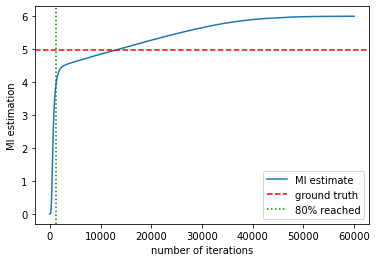

In [37]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
for t in range(len(mi_copy)):
    if (mi_copy[t]>.8*Ground_truth):
        plt.axvline(t,label='80% reached',linestyle=':',color='green')
        break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()

Save the model.

In [38]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'mi_copy': mi_copy,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.
